 # Symbolic Writhe Graph Laplacian

In [1]:
import sympy as sp
import numpy as np
def generate_writhe_adjacency_matrix(N):
    """
    Generate the adjacency writhe matrix W_adj for an N-node sequential graph.
    
    Parameters:
    N (int): Number of nodes in the graph.
    
    Returns:
    sympy.Matrix: The computed adjacency writhe matrix W_adj.
    """
    if N < 3:
        raise ValueError("N must be at least 3 to define nontrivial writhe values.")

    # Number of edges in a sequential path graph
    E = N - 1

    # Construct the incidence matrix B (N x E)
    B = sp.zeros(N, E)
    for i in range(E):
        B[i, i] = 1
        B[i + 1, i] = 1

    # Define symbolic writhe values for non-adjacent edges
    writhe_symbols = {}
    for i in range(E):
        for j in range(i + 2, E):  # Only non-adjacent edges
            writhe_symbols[(i, j)] = sp.Symbol(f"w{i+1}{j+1}")

    # Construct the upper triangular writhe matrix W_edge (E x E)
    W_edge = sp.zeros(E, E)
    for (i, j), symbol in writhe_symbols.items():
        W_edge[i, j] = symbol
        W_edge[j, i] = symbol  # Ensure symmetry

    # Compute W_adj = B W_edge B^T
    W_adj = B * W_edge * B.T

    return W_adj

# Example usage for N=5
n=5
sp.pprint(generate_writhe_adjacency_matrix(n))

⎡    0             0         w₁₃     w₁₃ + w₁₄        w₁₄   ⎤
⎢                                                           ⎥
⎢    0             0         w₁₃  w₁₃ + w₁₄ + w₂₄  w₁₄ + w₂₄⎥
⎢                                                           ⎥
⎢   w₁₃           w₁₃         0         w₂₄           w₂₄   ⎥
⎢                                                           ⎥
⎢w₁₃ + w₁₄  w₁₃ + w₁₄ + w₂₄  w₂₄         0             0    ⎥
⎢                                                           ⎥
⎣   w₁₄        w₁₄ + w₂₄     w₂₄         0             0    ⎦


# Numerical computation of writhe graph Laplacian for all frames of a 30 microsecond MD simulation of ACTR

2025-04-22 20:31:58,198	INFO worker.py:1852 -- Started a local Ray instance.


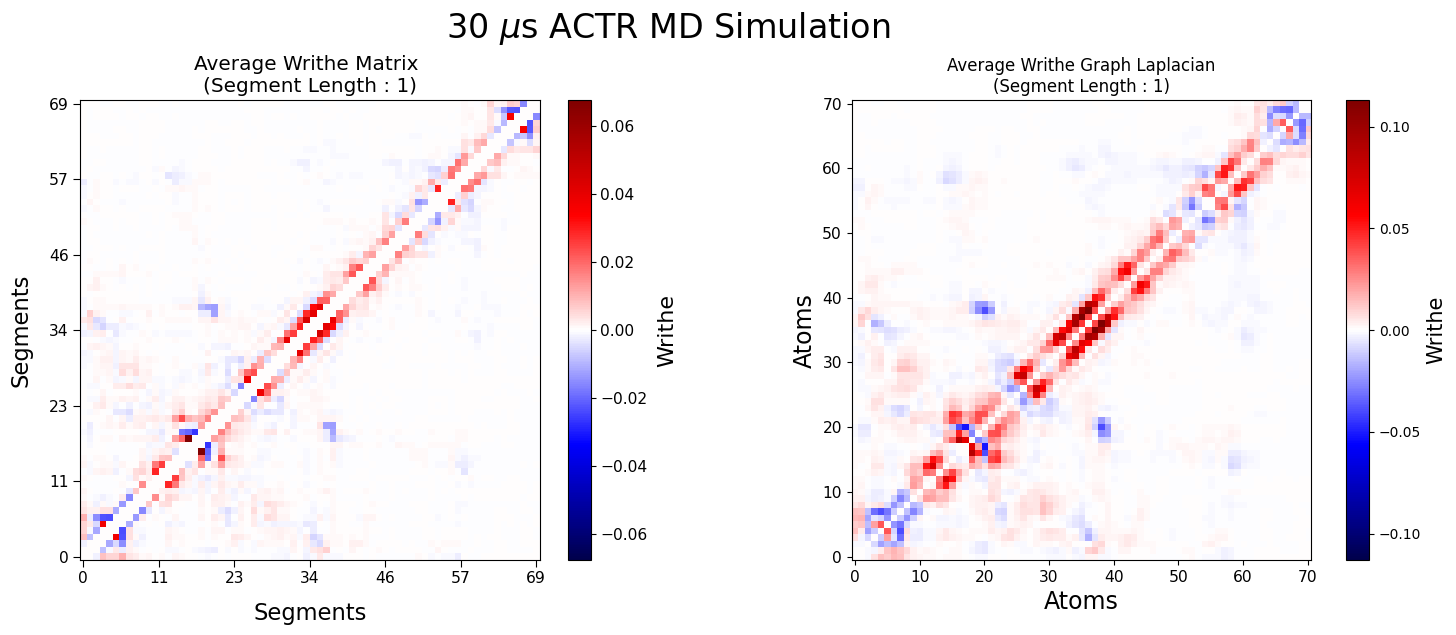

In [4]:
import torch
import numpy as np
from writhe_tools.writhe_nn import TorchWrithe
import matplotlib.pyplot as plt;
import matplotlib
import mdtraj as md

def unflatten_offdiag(x):
    """
    Reconstruct an (n x n) matrix from a flattened vector of off-diagonal elements,
    with zeros on the diagonal.
    """
    L = x.shape[0]
    # Solve n(n-1) = L => n = (1 + sqrt(1 + 4L)) / 2
    n = int((1 + (1 + 4 * L) ** 0.5) / 2)
    assert n * (n - 1) == L, "Invalid length: does not match off-diagonal of any square matrix"

    mat = torch.zeros(n, n, dtype=x.dtype, device=x.device)
    off_diag_mask = ~torch.eye(n, dtype=bool, device=x.device)
    mat[off_diag_mask] = x
    return mat


from writhe_tools.writhe import Writhe
data = np.load("/data/writhe_paper_data/actr/ca_coordinates.npy")
writhe = Writhe(data)
_=writhe.compute_writhe(1)


fig, ax = plt.subplots(1,2, figsize=(16, 6))
writhe.plot_writhe_matrix(ax=ax[0], font_scale=1.6, label_stride=9, rotation=0, ylabel="Segments", xlabel="Segments")


layer = TorchWrithe(n_atoms=data.shape[1])
L = layer(torch.from_numpy(data), vector=True)[0]

vmax = abs(L.mean(0)).max()
norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-1 * vmax, vmax=vmax)
s=ax[-1].imshow(unflatten_offdiag(L.mean(0).flatten()).cpu().numpy(), cmap="seismic", norm=norm)
cb=plt.colorbar(s, ax=ax[-1], fraction=.045, label='writhe')
cb.set_label('Writhe', size=15)
ax[-1].set_title("Average Writhe Graph Laplacian\n(Segment Length : 1)")
ax[-1].invert_yaxis()
fig.tight_layout()
ax[-1].set_ylabel("Atoms", size=17)
ax[-1].set_xlabel("Atoms", size=17)
ax[-1].tick_params( labelsize=7  * 1.6)
fig.suptitle(r"30 $\mu$s ACTR MD Simulation", y=1.05, fontsize=24)
plt.savefig("./writhe_matrix_laplacian.png", dpi=1000, bbox_inches="tight")